# Using Otsu's method to classify water area

### Flowchart

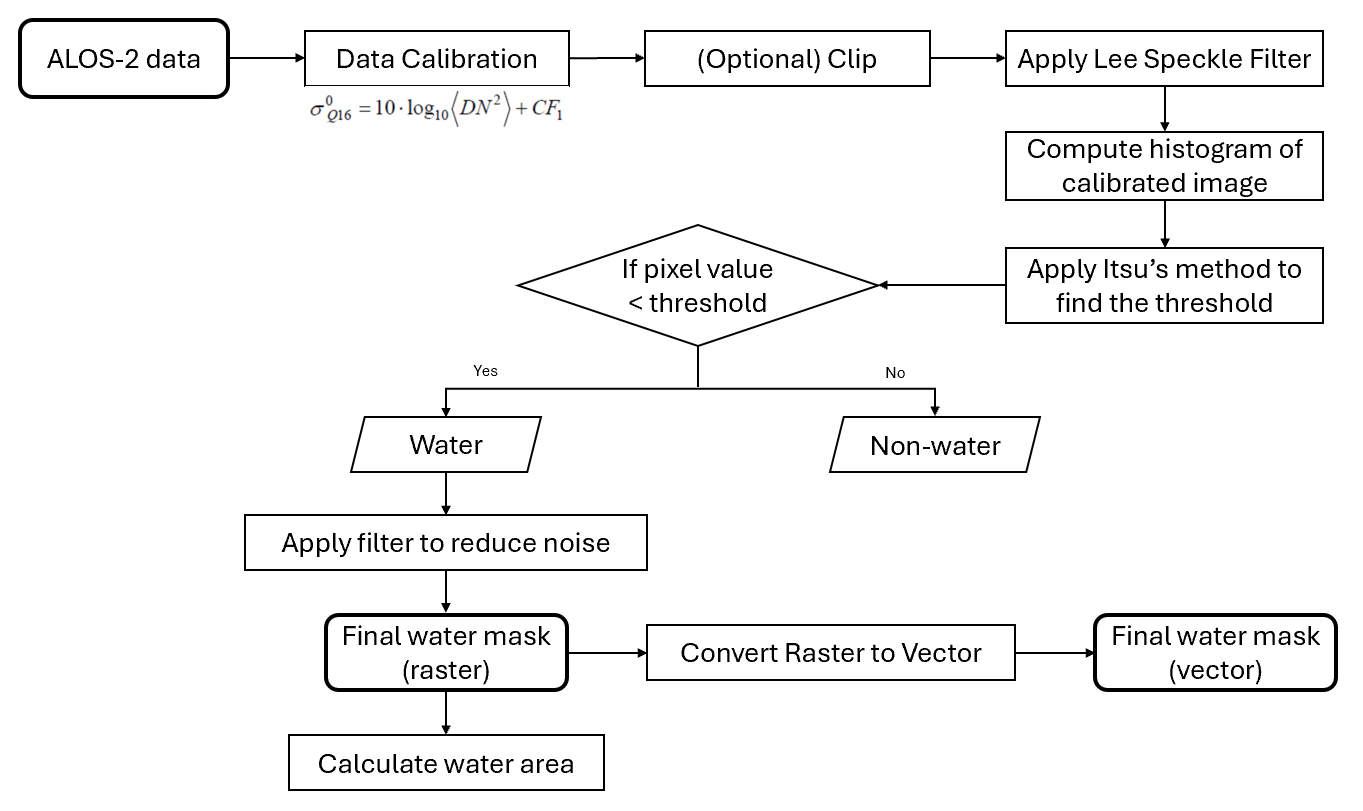

In this study, we will use the ALOS-2 data from JAXA. However, this hands-on use the sample data that downloaded from JAXA's website.

After got the data, apply Radiometric calibration factors to convert digital number to backscatter value.

**NOTE**: Radiometric calibration is crucial for converting ALOS-2 SAR data into physically meaningful values (like backscatter) that accurately represent the reflectivity of the Earth's surface. It ensures that the data is corrected for sensor biases, comparable across different sensors or acquisition times, and suitable for detailed analysis like environmental monitoring, land use classification, and disaster management.


### Data calibration
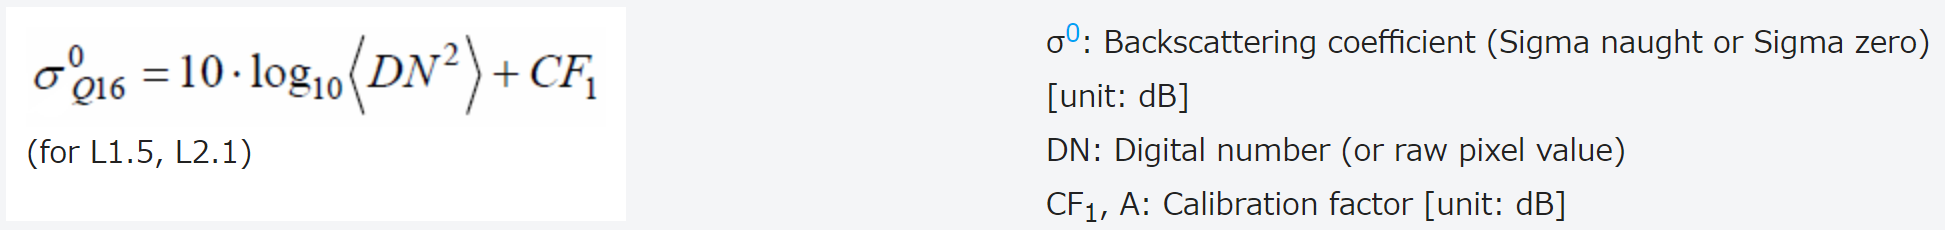
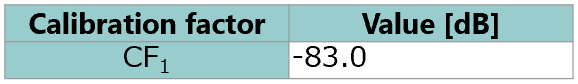
- You can use this formula in Raster calculator in **QGIS** to calibrate the data using formula:

  (20*log10(ALOS-2 data))-83

##### NOTE: In this hands-on, we use calibrated data as an input data.

In [1]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install geopandas

  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached pyogrio-0.10.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached pyproj-3.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached shapely-2.0.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.0 kB)
Using cached geopandas-1.0.1-py3-none-any.whl (323 kB)
Using cached pyogrio-0.10.0-cp311-cp311-manylinux_2_28_x86_64.whl (24.1 MB)
Using cached pyproj-3.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached shapely-2.0.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio.mask
from scipy.ndimage import uniform_filter

## Load the ALOS-2 image

In [5]:
# Load the ALOS-2 image
ALOS_image_path = '/home/jovyan/shared/Arissara/ALOS-2/N01E102_sl_HH_.tif'

## Visualize the original full image

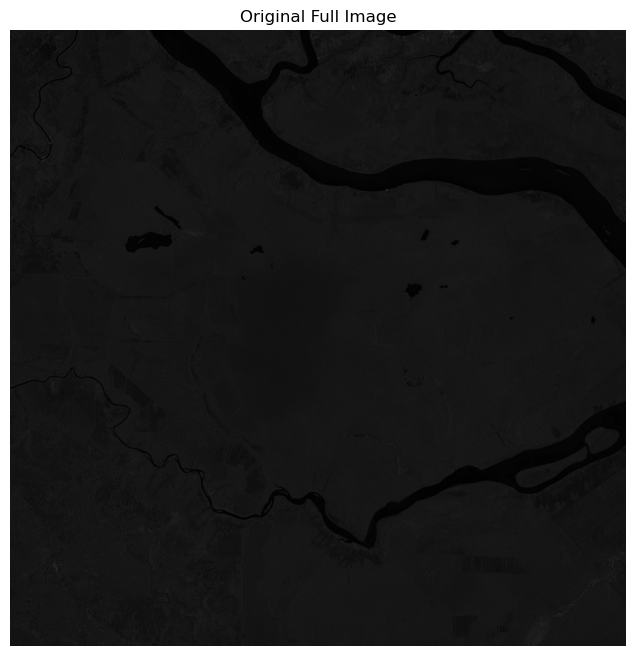

In [7]:
# Step to visualize the original full image
with rasterio.open(ALOS_image_path) as src:
    original_image = src.read(1)  # Read the first band for visualization
    profile = src.profile  # Keep the profile for exporting

def visualize_original(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.title('Original Full Image')
    plt.axis('off')
    plt.show()

# Visualize the original full image
visualize_original(original_image)

## Apply the calibration expression

In [11]:
# Apply the calibration formula to the image
calibrated_image = (20 * np.log10(original_image)) - 83

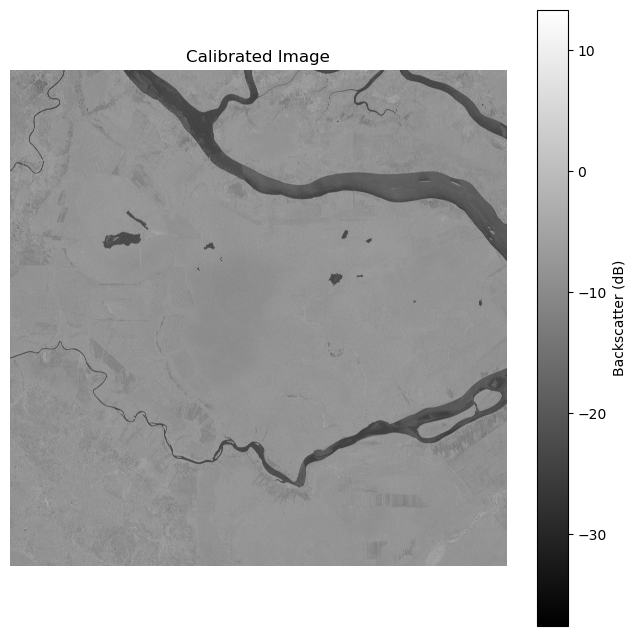

In [12]:
# Function to visualize the calibrated image
def visualize_calibrated(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.title('Calibrated Image')
    plt.colorbar(label='Backscatter (dB)')
    plt.axis('off')
    plt.show()

# Visualize the calibrated image
visualize_calibrated(calibrated_image)

In [10]:
# Export the calibrated image
export_path = '/home/jovyan/shared/Arissara/ALOS-2/hands-on/calib_N01E102_sl_HH_.tif'

# Update profile for float32 data type
profile.update(dtype=rasterio.float32)

# Save the calibrated image as a GeoTIFF
with rasterio.open(export_path, 'w', **profile) as dst:
    dst.write(calibrated_image.astype(rasterio.float32), 1)  # Save the image as float32

## Classify water area

In [4]:
import numpy as np
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from skimage import filters

In [5]:
# Load the ALOS-2 image
image_path = '/home/jovyan/shared/Arissara/ALOS-2/calibration/calib_N01E102_sl_HH_.tif'
with rasterio.open(image_path) as src:
    image = src.read(1)  # Reading the first band (VH or VV)
    profile = src.profile
    transform = src.transform
    bounds = src.bounds

### [Lee filter](https://www.researchgate.net/publication/239659062_Speckle_filtering_of_synthetic_aperture_radar_images_A_Review)

The **Lee Speckle Filter** is a technique used to reduce speckle noise in SAR (Synthetic Aperture Radar) imagery. Speckle noise is a granular noise that naturally occurs in SAR images due to the coherent nature of radar systems, where each pixel contains multiple scatterers contributing to the same radar return signal. This noise degrades the quality of the image and makes interpretation or further analysis difficult.

#### How the **Lee Filter** Works:
- The **Lee Filter** is an adaptive filter that assumes the underlying image has a piecewise-constant signal (i.e., smooth surfaces, separated by edges) and that speckle noise is multiplicative. 
- It works by calculating the local statistics (mean and variance) over a moving window of the image.
- The filter preserves the edges and other significant features while smoothing homogeneous areas. It adapts based on the local variance of the image pixels: areas of low variance (homogeneous regions) are heavily smoothed, while areas of high variance (edges, boundaries) are less smoothed.#

### Why Use the **Lee Speckle Filter** on ALOS PALSAR-2 Data?
ALOS PALSAR-2 is a type of SAR sensor that generates radar data, often affected by speckle noise. Applying the Lee Speckle Filter on ALOS PALSAR-2 data helps in:
1. **Noise Reduction:** It reduces speckle noise while preserving important image details such as edges.
2. **Improved Interpretation:** Cleaned images allow for better visual interpretation and feature extraction.
3. **Better Analysis:** For quantitative analysis like classification, change detection, or biomass estimation, reduced speckle helps improve the accuracy oh the link above.

### References:
 - [Digital Image Enhancement and Noise Filtering by Use of Local Statistics](https://ieeexplore.ieee.org/document/4766994?rsource=https:%2F%2Flinks.esri.com%2FNoiseFilteringUsingLocalStats)

 - Sentinel Online SAR Toolbox: [Speckle Filtering](https://sentinel.esa.int/web/sentinel/toolboxes/sentinel-1/speckle-filtering)

The provided code implements a **Lee filter**, which is commonly used to reduce speckle noise in Synthetic Aperture Radar (SAR) images. It works by processing each pixel in the image using a sliding window (of size defined by `window_size`). For each window, it calculates the local mean and variance to determine a damping factor \( k \), which controls how much smoothing is applied to the pixel. The filter smooths homogeneous areas (low variance) while preserving detail in regions with high variance (like edges). The resulting `filtered_image` is a noise-reduced version of the input image.

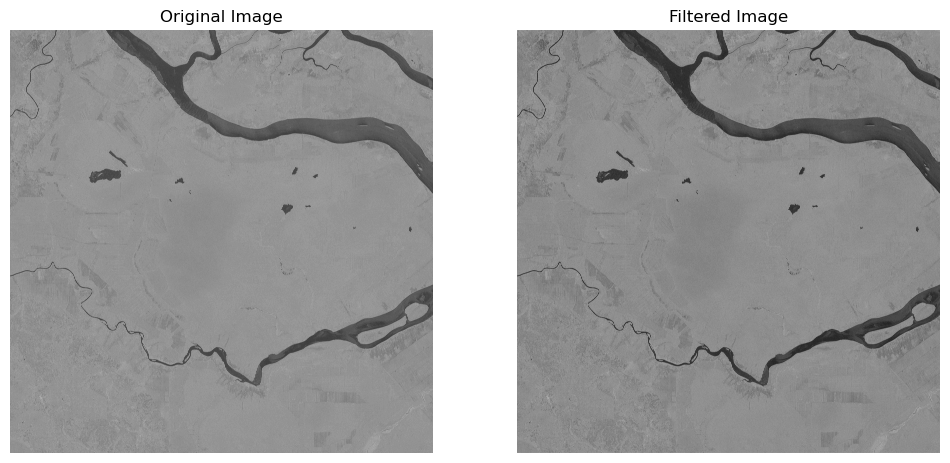

In [6]:
import numpy as np
from skimage import io, color, img_as_float
from skimage.restoration import denoise_tv_chambolle
from skimage.filters import median
from skimage.morphology import disk
import matplotlib.pyplot as plt

def lee_filter(image, window_size=3):
    # Convert image to float for processing
    image = img_as_float(image)
    
    # Initialize the output image
    filtered_image = np.zeros_like(image)

    # Define the window size for the Lee filter
    half_window = window_size // 2

    # Loop over the image and apply the Lee filter
    for i in range(half_window, image.shape[0] - half_window):
        for j in range(half_window, image.shape[1] - half_window):
            window = image[i-half_window:i+half_window+1, j-half_window:j+half_window+1]
            mean = np.mean(window)
            variance = np.var(window)
            local_mean = np.mean(window)
            local_variance = np.var(window)
            
            if local_variance > 0:
                k = local_variance / (local_variance + variance)
            else:
                k = 0
            
            filtered_image[i, j] = mean + k * (image[i, j] - mean)

    return filtered_image

# Load an example image
#image = io.imread('https://example.com/path/to/your/image.png', as_gray=True)

# Apply the Lee filter
filtered_image = lee_filter(image, window_size=5)

# Display the original and filtered images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(filtered_image, cmap='gray')
ax[1].set_title('Filtered Image')
ax[1].axis('off')

plt.show()

This code computes and visualizes the histogram of the image, which represents the distribution of pixel intensities. It uses `numpy.histogram` to calculate the histogram with 255 bins, corresponding to pixel intensities in the image. The **mean** and **variance** of the pixel values are computed to help describe the distribution. The plot includes vertical dashed lines at the mean (red) and one standard deviation (green) above and below the mean, providing visual markers for the central tendency and spread of the data. The plot is labeled with these values for better interpretation, with titles and axis labels to enhance clarity. This visualization helps assess the overall contrast and intensity distribution in the image.

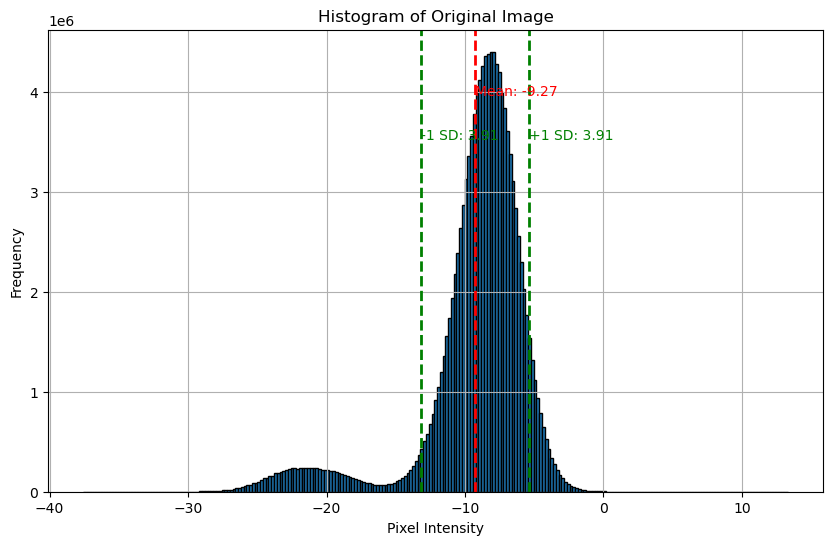

In [7]:
# Compute the histogram for the original image
hist, bin_edges = np.histogram(image, bins=255)
mean_val = np.mean(image)
var_val = np.var(image)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor='black', align='edge')

# Annotate the mean and variance on the plot
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2)
plt.text(mean_val, max(hist) * 0.9, f'Mean: {mean_val:.2f}', color='red')

plt.axvline(mean_val + np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.axvline(mean_val - np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.text(mean_val + np.sqrt(var_val), max(hist) * 0.8, f'+1 SD: {np.sqrt(var_val):.2f}', color='green')
plt.text(mean_val - np.sqrt(var_val), max(hist) * 0.8, f'-1 SD: {np.sqrt(var_val):.2f}', color='green')

# Add titles and labels
plt.title('Histogram of Original Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

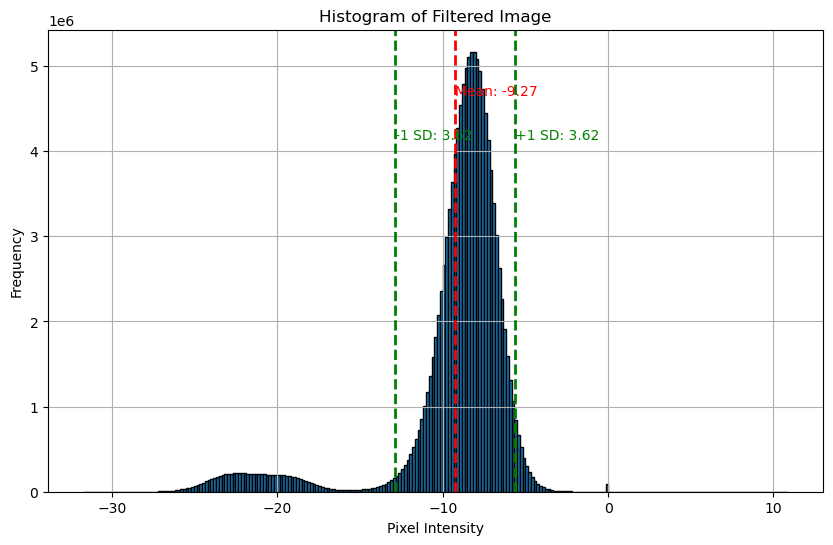

In [8]:
# Compute the histogram for the Filtered image
hist, bin_edges = np.histogram(filtered_image, bins=255)
mean_val = np.mean(filtered_image)
var_val = np.var(filtered_image)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor='black', align='edge')

# Annotate the mean and variance on the plot
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2)
plt.text(mean_val, max(hist) * 0.9, f'Mean: {mean_val:.2f}', color='red')

plt.axvline(mean_val + np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.axvline(mean_val - np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.text(mean_val + np.sqrt(var_val), max(hist) * 0.8, f'+1 SD: {np.sqrt(var_val):.2f}', color='green')
plt.text(mean_val - np.sqrt(var_val), max(hist) * 0.8, f'-1 SD: {np.sqrt(var_val):.2f}', color='green')

# Add titles and labels
plt.title('Histogram of Filtered Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

### (Optional)

If you encountered the error **ValueError: autodetected range of [nan, nan] is not finite** when compute the histogram, run the cell below to compute the histogram. However, if you don't encountered this error, skip this (Optional) step, and continue to Otsu's method part.


For error **ValueError: autodetected range of [nan, nan] is not finite**,

We should ensure that the image does not contain NaN, infinite (inf), or negative infinite (-inf) values before computing the histogram for several reasons:

1. NaN and Inf Values Are Undefined in Histograms:
NaN (Not a Number) and inf (infinite) values are not valid numerical values for most statistical computations, including histograms. A histogram requires valid, finite numbers to count occurrences in specific ranges (bins).
If a histogram encounters NaN or inf values, it could cause errors or produce meaningless results because these values don't belong to any meaningful range of real numbers.
2. Impact on Histogram Accuracy:
If NaN or inf values are not handled, the computed histogram would be inaccurate, as the presence of these invalid values can distort the representation of the data. It might either skew the distribution or lead to missing data points in the histogram.
3. Prevention of Errors in Visualization:
Histogram plotting libraries (like those in matplotlib or numpy) typically expect clean numerical arrays. NaN, inf, or -inf values can trigger errors, causing the code to crash or preventing the histogram from being generated.
4. Ensuring Data Consistency:
Replacing NaN, inf, and -inf values with valid numbers (in this case, 0) ensures consistency in the data. This replacement allows the histogram computation to proceed smoothly without interruptions, resulting in a histogram that accurately reflects the meaningful parts of the data.

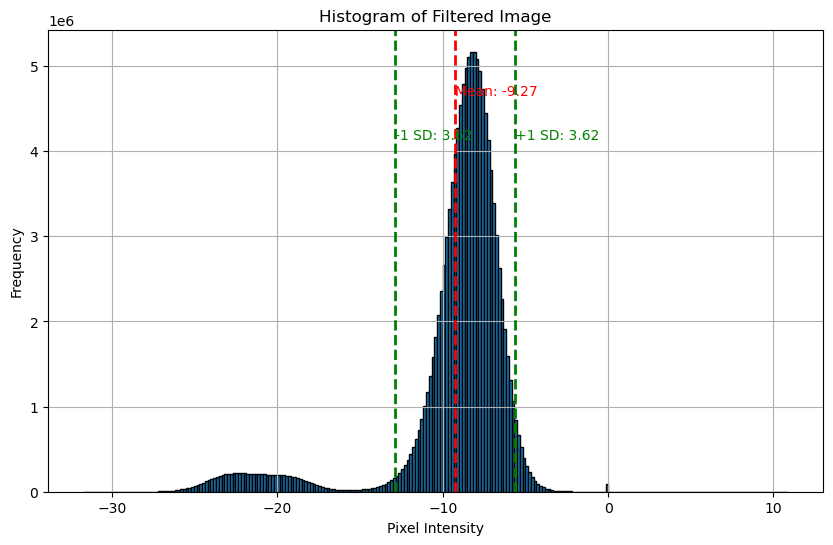

In [7]:
# Handle NaN values by replacing them with 0 or any other specified value
filtered_image_clean = np.nan_to_num(filtered_image, nan=0.0)

# Compute the histogram for the cleaned filtered image
hist, bin_edges = np.histogram(filtered_image_clean, bins=255)

# Compute mean and variance, ignoring NaN values (already cleaned)
mean_val = np.mean(filtered_image_clean)
var_val = np.var(filtered_image_clean)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor='black', align='edge')

# Annotate the mean and variance on the plot
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2)
plt.text(mean_val, max(hist) * 0.9, f'Mean: {mean_val:.2f}', color='red')

plt.axvline(mean_val + np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.axvline(mean_val - np.sqrt(var_val), color='green', linestyle='dashed', linewidth=2)
plt.text(mean_val + np.sqrt(var_val), max(hist) * 0.8, f'+1 SD: {np.sqrt(var_val):.2f}', color='green')
plt.text(mean_val - np.sqrt(var_val), max(hist) * 0.8, f'-1 SD: {np.sqrt(var_val):.2f}', color='green')

# Add titles and labels
plt.title('Histogram of Filtered Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()


### Otsu's method

In [9]:
from skimage.filters import threshold_otsu

In [10]:
# Apply Otsu's method to find the threshold
threshold = threshold_otsu(filtered_image)
print(f'Otsu Threshold: {threshold}')

Otsu Threshold: -14.83749008178711


In [11]:
# Create the binary water mask
water_mask = filtered_image < threshold

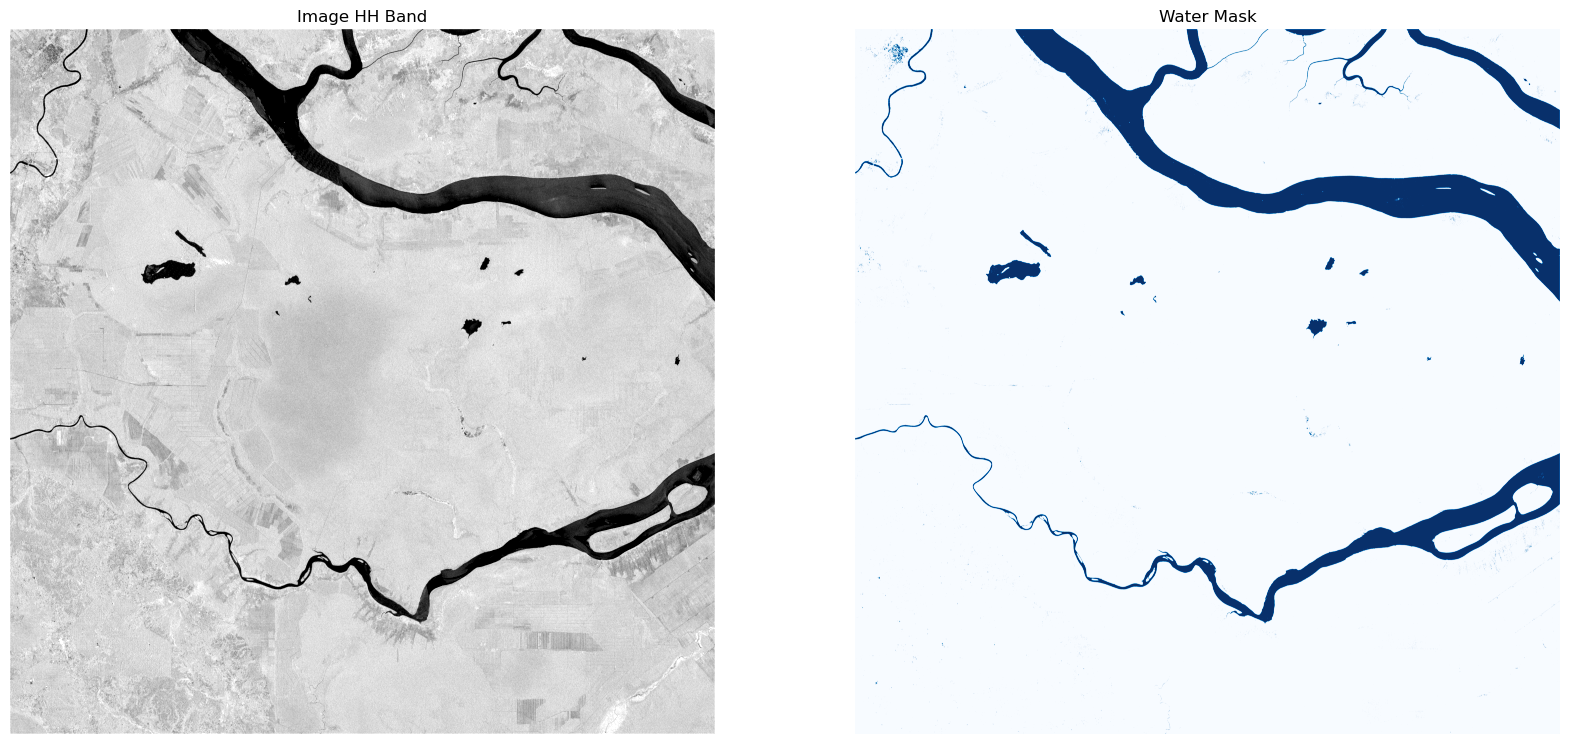

In [12]:
#import numpy as np
#import matplotlib.pyplot as plt

# Ensure image_filtered has valid numeric values
image = np.nan_to_num(filtered_image, nan=-30, posinf=-3, neginf=-30)

# Convert to float if necessary
image = filtered_image.astype(float)

# Adjust vmin and vmax based on data range
vmin = np.percentile(filtered_image, 2)
vmax = np.percentile(filtered_image, 98)

# Visualize the filtered image and the water mask
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))  # Increase figure size if necessary
ax1.imshow(filtered_image, cmap='gray', vmin=vmin, vmax=vmax)
ax1.set_title('Image HH Band')
ax1.axis('off')

ax2.imshow(water_mask, cmap='Blues')
ax2.set_title('Water Mask')
ax2.axis('off')

plt.show()

In [13]:
# Export the water mask as a GeoTIFF with Float32
output_path = '/home/jovyan/shared/Arissara/ALOS-2/hands-on/test/lee_calib_N01E102_sl_HH_water_mask.tif'
profile.update(dtype=rasterio.float32, count=1)
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(water_mask.astype(np.float32), 1)

### Remove noise

The step below use a **median filter** to remove noise from the water mask because it is highly effective at preserving edges while removing small, isolated noise artifacts.
U using a **3x3 window** in the median filter, small noisk is smoothed out, while larger features, like water bodies, remain intact, ensuring a cleaner and more accurate representation of the water areas.

In [14]:
# Import necessary libraries
import rasterio
from scipy.ndimage import median_filter
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Path to the GeoTIFF file
input_tiff = '/home/jovyan/shared/Arissara/ALOS-2/hands-on/test/lee_calib_N01E102_sl_HH_water_mask.tif'
output_tiff = '/home/jovyan/shared/Arissara/ALOS-2/hands-on/test/rm-noiselee_calib_N01E102_sl_HH_water_mask.tif'

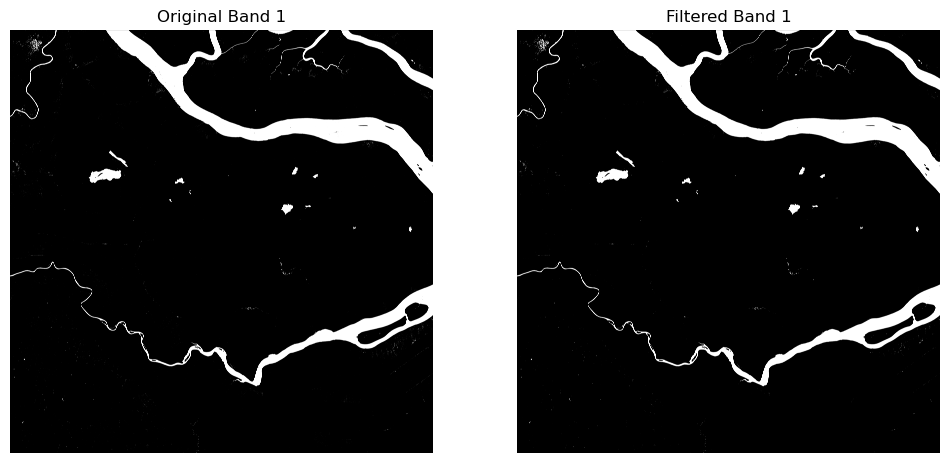

In [16]:
# Open the GeoTIFF file using rasterio
with rasterio.open(input_tiff) as src:
    # Read all bands of the GeoTIFF
    bands = src.read()
    
    # Get metadata (for writing the output file)
    meta = src.meta
    
# Apply median filter to each band to remove noise
filtered_bands = np.zeros_like(bands)
for i in range(bands.shape[0]):
    filtered_bands[i] = median_filter(bands[i], size=3)  # size=3 means a 3x3 kernel for filtering

# Write the filtered image to a new GeoTIFF file
with rasterio.open(output_tiff, 'w', **meta) as dst:
    dst.write(filtered_bands)

# Optionally, display the original and filtered bands (e.g., the first band)
plt.figure(figsize=(12, 6))

# Original image (first band)
plt.subplot(1, 2, 1)
plt.imshow(bands[0], cmap='gray')
plt.title('Original Band 1')
plt.axis('off')

# Filtered image (first band)
plt.subplot(1, 2, 2)
plt.imshow(filtered_bands[0], cmap='gray')
plt.title('Filtered Band 1')
plt.axis('off')

plt.show()

### Calculate water area

In [24]:
# Assuming roi is defined as a bounding box: (min_lon, min_lat, max_lon, max_lat)
##roi = [133.6341032752386866, 34.4100997954243155, 133.9596877832316864, 34.6186143745820587]
roi = [102.0000000000000000,0.0000000000000000, 103.0000000000000000,1.0000000000000000]

# Calculate the midpoint latitude of the ROI
latitude = (roi[1] + roi[3]) / 2  # (min_lat + max_lat) / 2

# Use the latitude to calculate the conversion factor from degrees to meters
meters_per_degree = 111320 * np.cos(np.radians(latitude))  # Adjust based on latitude

pixel_width_deg = abs(profile['transform'][0])
pixel_height_deg = abs(profile['transform'][4])

# Convert pixel dimensions from degrees to meters
pixel_width_m = pixel_width_deg * meters_per_degree
pixel_height_m = pixel_height_deg * meters_per_degree

# Calculate pixel area in square meters
pixel_area = pixel_width_m * pixel_height_m
print(f"Pixel area (in square meters): {pixel_area:.2f}")

# Calculate the area covered by water in hectares
water_area_ha = np.sum(filtered_bands) * pixel_area / 10000  # convert to hectares
print(f'Water Area: {water_area_ha:.2f} hectares')

Pixel area (in square meters): 100.00
Water Area: 84109.39 hectares


### Convert raster to vector

In [25]:
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape
import numpy as np

In [26]:
# Path to the input raster file
input_raster = '/home/jovyan/shared/Arissara/ALOS-2/hands-on/test/rm-noiselee_calib_N01E102_sl_HH_water_mask.tif'
output_vector = '/home/jovyan/shared/Arissara/ALOS-2/hands-on/test/rm-noiselee_calib_N01E102_sl_HH_water_mask.gpkg'  # You can change to .geojson or .gpkg

In [27]:
# Open the raster file using rasterio
with rasterio.open(input_raster) as src:
    # Read the first band (or all bands depending on your needs)
    raster = src.read(1)
    
    # Get the affine transform to preserve the spatial coordinates
    transform = src.transform
    
    # Get the coordinate reference system (CRS)
    crs = src.crs

# Optional: Threshold the raster (e.g., binary mask)
# This is only required if you want to extract certain areas based on the raster values
binary_raster = raster > 0  # Example threshold, adjust based on your data

# Vectorize the raster using rasterio.features.shapes to generate polygons
results = (
    {'properties': {'value': v}, 'geometry': shape(s)}
    for s, v in shapes(binary_raster.astype(np.int16), transform=transform)
)

# Convert the result to a GeoDataFrame (which supports geospatial vector data)
geoms = list(results)
gdf = gpd.GeoDataFrame.from_features(geoms, crs=crs.to_string())  # Set CRS to match the raster

# Save the vectorized output to a file (Shapefile, GeoJSON, GPKG)
gdf.to_file(output_vector, driver="GPKG")  # You can change the format here

# Optionally, display a summary of the vector data
print(gdf.head())


                                            geometry  value
0  POLYGON ((102.54883 0.99973, 102.54883 0.99964...    1.0
1  POLYGON ((102.73102 0.99955, 102.73102 0.99928...    1.0
2  POLYGON ((102.11994 0.99919, 102.11994 0.9991,...    1.0
3  POLYGON ((102.82949 0.9991, 102.82949 0.99901,...    1.0
4  POLYGON ((102.13772 0.99919, 102.13772 0.99901...    1.0


### Appendix

Download sample data from 
- [ALOS-2 / PALSAR-2 Sample Product](https://www.eorc.jaxa.jp/ALOS/en/alos-2/datause/a2_sample_e.htm)
- [PALSAR 10m Mosaic Data](https://www.eorc.jaxa.jp/ALOS/en/dataset/fnf/pal_10m_mosaic_e.htm)